## Matrix Factorization

In [314]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm import tqdm

In [315]:
ratings = pd.read_csv('./dataset/ratings_small.csv')

### 데이터 확인

In [316]:
print(ratings.head())
print(ratings.info())
print(ratings.describe())

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
              userId        movieId         rating     timestamp
count  100004.000000  100004.000000  100004.000000  1.000040e+05
mean      347.011310   12548.664363       3.543608  1.129639e+09
std       195.163838   26369.198969       1.058064  1.916858e+08
min         1.000000       1.000000       0.500000  7.896520e+08
25%       182.000000    1028.0

### 누락값 처리

In [317]:
missing_values = ratings.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [318]:
ratings = ratings.dropna()
print("After dropping missing values:\n", ratings.isnull().sum())

After dropping missing values:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


### 이상치 처리

In [319]:
print("Ratings outside the valid range:")
invalid_ratings = ratings[(ratings['rating'] < 0.5) | (ratings['rating'] > 5.0)]
print(invalid_ratings)

Ratings outside the valid range:
Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []


In [320]:
ratings = ratings[(ratings['rating'] >= 0.5) & (ratings['rating'] <= 5.0)]
print(f"After removing invalid ratings, dataset size: {ratings.shape}")

After removing invalid ratings, dataset size: (100004, 4)


### 중복 처리

In [321]:
duplicates = ratings.duplicated(subset=['userId', 'movieId'])
print(f"Number of duplicate entries: {duplicates.sum()}")

Number of duplicate entries: 0


In [322]:
ratings = ratings.drop_duplicates(subset=['userId', 'movieId'], keep='last')
print(f"After removing duplicates, dataset size: {ratings.shape}")

After removing duplicates, dataset size: (100004, 4)


### 불필요 열 제거

In [323]:
ratings = ratings.drop(columns=['timestamp'])

### 데이터 정수화

In [324]:
user_map = {u: i for i, u in enumerate(ratings['userId'].unique())}
item_map = {i: j for j, i in enumerate(ratings['movieId'].unique())}

ratings['userId'] = ratings['userId'].map(user_map)
ratings['movieId'] = ratings['movieId'].map(item_map)

num_users = len(user_map)
num_items = len(item_map)

print(f"Number of users: {num_users}, Number of items: {num_items}")

Number of users: 671, Number of items: 9066


### 최종 데이터

In [325]:
print(ratings.info())
print(ratings.describe())
print(ratings.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB
None
              userId        movieId         rating
count  100004.000000  100004.000000  100004.000000
mean      346.011310    1660.778349       3.543608
std       195.163838    1893.955817       1.058064
min         0.000000       0.000000       0.500000
25%       181.000000     327.000000       3.000000
50%       366.000000     873.000000       4.000000
75%       519.000000    2344.000000       4.000000
max       670.000000    9065.000000       5.000000
   userId  movieId  rating
0       0        0     2.5
1       0        1     3.0
2       0        2     3.0
3       0        3     2.0
4       0        4     4.0


### 데이터 변환 for Torch

In [326]:
import pandas as pd
import numpy as np

# ratings DataFrame 예시: columns: ['userId', 'movieId', 'rating', ...]
train_data = ratings.copy()

test_ratio = 0.1  # 각 사용자별로 최대 20%를 test로
train_rows = []
test_rows = []

# 사용자별 그룹핑
grouped = train_data.groupby('userId', group_keys=False)

for userId, group in grouped:
    # 사용자의 평점 레코드 섞기 (무작위 샘플링)
    group = group.sample(frac=1, random_state=42)

    n = len(group)
    test_size = int(n * test_ratio)

    # 사용자별로 최소 80% 이상은 train에 있어야 하므로, test_size가 n * 0.2 이하를 만족
    # test_size 계산은 위에서 했으며, 예를 들어 test_size = floor(n * 0.2)

    # 유저 레코드가 매우 적어서 test_size가 0이거나, test_size가 너무 커질 경우 조정 가능
    # 여기서는 test_size 그대로 사용하고, test_size가 0이면 해당 유저는 test에 없음
    # test_size가 n보다 같거나 크면 안되므로 check
    if test_size > 0 and test_size < n:
        test_data = group.iloc[:test_size]
        train_data_user = group.iloc[test_size:]
    else:
        # test_size == 0 또는 너무 커서 분할 불가능한 경우 test 없이 전부 train에 할당
        test_data = pd.DataFrame(columns=group.columns)
        train_data_user = group

    train_rows.append(train_data_user)
    test_rows.append(test_data)

train_data = pd.concat(train_rows, ignore_index=True)
test_data = pd.concat(test_rows, ignore_index=True)

print("Train set size:", len(train_data))
print("Test set size:", len(test_data))

Train set size: 90282
Test set size: 9722


In [327]:
train_users = torch.LongTensor(train_data['userId'].values)
train_items = torch.LongTensor(train_data['movieId'].values)
train_ratings = torch.FloatTensor(train_data['rating'].values)

test_users = torch.LongTensor(test_data['userId'].values)
test_items = torch.LongTensor(test_data['movieId'].values)
test_ratings = torch.FloatTensor(test_data['rating'].values)

### 모델 정의

In [328]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, latent_dim):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)

    def forward(self, user_ids, item_ids):
        user_embedding = self.user_embedding(user_ids)
        item_embedding = self.item_embedding(item_ids)
        pred = (user_embedding * item_embedding).sum(dim=1)
        return pred

### 모델 하이퍼 파라미터 설정

In [329]:
latent_dim = 60
model = MatrixFactorization(num_users, num_items, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)

num_epochs = 2000
batch_size = 256

### Train

In [330]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    with tqdm(total=len(train_users), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="users") as pbar:
        for i in range(0, len(train_users), batch_size):
            user_ids = train_users[i:i+batch_size]
            item_ids = train_items[i:i+batch_size]
            ratings = train_ratings[i:i+batch_size]

            optimizer.zero_grad()
            predictions = model(user_ids, item_ids)
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * len(user_ids)
            
            pbar.set_postfix(loss=f"{loss.item():.4f}")
            pbar.update(len(user_ids))

Epoch 2000/2000: 100%|██████████| 90282/90282 [00:01<00:00, 68767.32users/s, loss=0.0900]


### Evaluation

In [331]:
model.eval()
with torch.no_grad():
    test_predictions = model(test_users, test_items)
    mse = ((test_predictions - test_ratings) ** 2).mean().item()
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")

with torch.no_grad():
    test_predictions = model(test_users, test_items) 
    test_predictions = torch.clamp(test_predictions, min=0, max=5) 

    differences = torch.abs(test_predictions - test_ratings) 
    accurate_predictions = (differences <= 0.5).sum().item() 
    accuracy = accurate_predictions / len(test_ratings) * 100 

    print(f"Accuracy: {accuracy:.2f}%")

RMSE: 1.2626
Accuracy: 38.37%


Threshold = 0.0, Accuracy = 2.13%
Threshold = 0.1, Accuracy = 9.48%
Threshold = 0.2, Accuracy = 16.94%
Threshold = 0.3, Accuracy = 24.37%
Threshold = 0.4, Accuracy = 30.90%
Threshold = 0.5, Accuracy = 38.37%
Threshold = 0.6, Accuracy = 44.39%
Threshold = 0.7, Accuracy = 49.79%
Threshold = 0.8, Accuracy = 55.09%
Threshold = 0.9, Accuracy = 59.43%
Threshold = 1.0, Accuracy = 65.36%
Threshold = 1.1, Accuracy = 69.12%
Threshold = 1.2, Accuracy = 72.74%
Threshold = 1.3, Accuracy = 75.69%
Threshold = 1.4, Accuracy = 78.33%
Threshold = 1.5, Accuracy = 81.28%
Threshold = 1.6, Accuracy = 83.41%
Threshold = 1.7, Accuracy = 85.44%
Threshold = 1.8, Accuracy = 87.07%
Threshold = 1.9, Accuracy = 88.42%
Threshold = 2.0, Accuracy = 90.40%


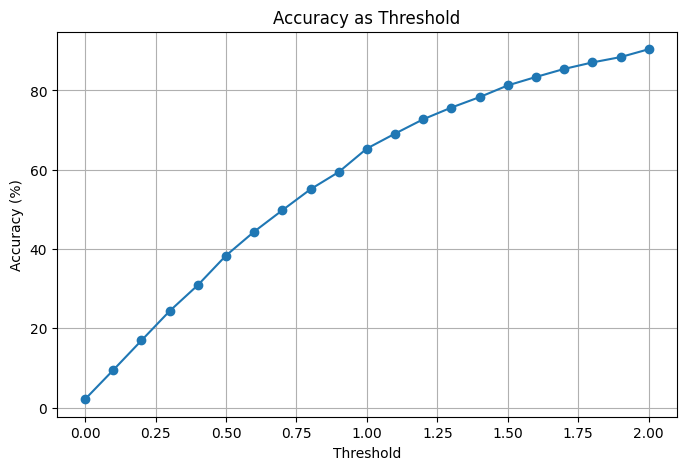

In [332]:
import matplotlib.pyplot as plt

with torch.no_grad():
    test_predictions = model(test_users, test_items)
    test_predictions = torch.clamp(test_predictions, min=0, max=5)

    # 다양한 threshold 값들 정의
    thresholds = np.arange(0.0, 2.1, 0.1)  # 0.0부터 1.0까지 0.1 단위
    accuracies = []

    differences = torch.abs(test_predictions - test_ratings)

    for t in thresholds:
        accurate_predictions = (differences <= t).sum().item()
        accuracy = accurate_predictions / len(test_ratings) * 100
        accuracies.append(accuracy)

    # 결과 출력
    for t, acc in zip(thresholds, accuracies):
        print(f"Threshold = {t:.1f}, Accuracy = {acc:.2f}%")

    # 그래프 그리기
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, accuracies, marker='o')
    plt.title('Accuracy as Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.show()

### 결과 분석

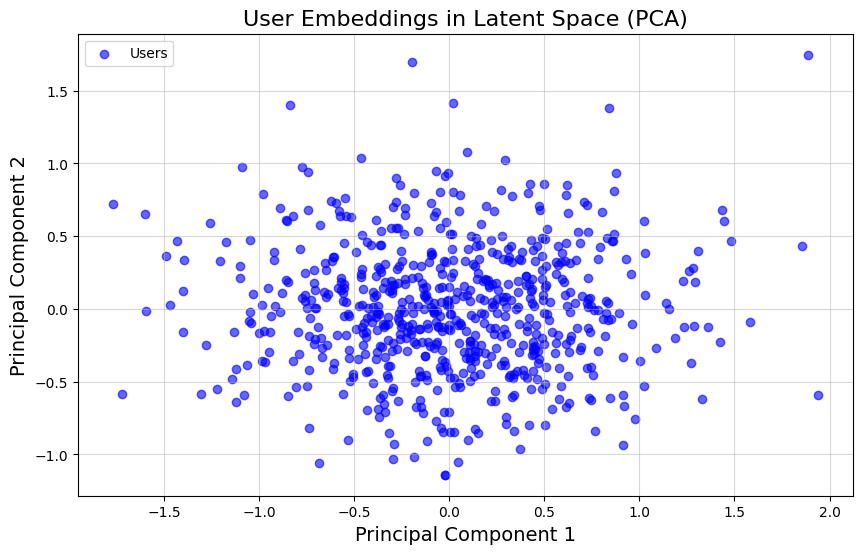

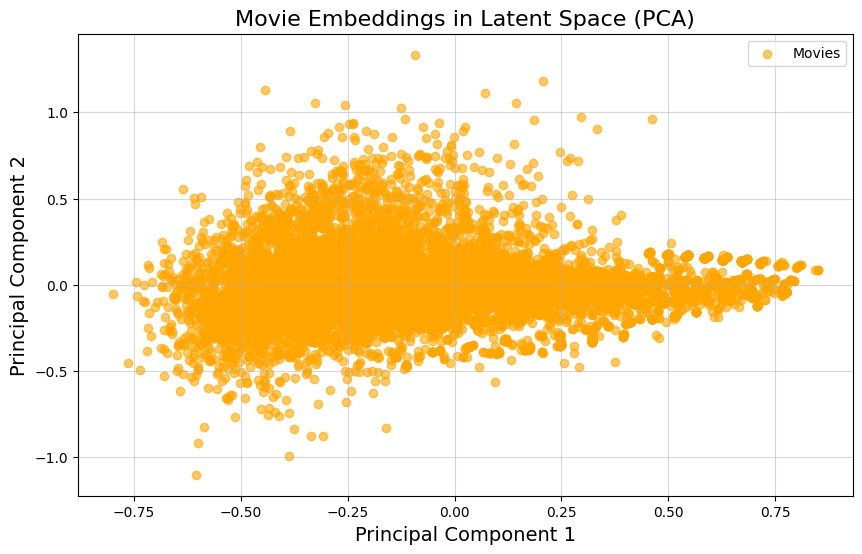

In [333]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

user_embeddings = model.user_embedding.weight.detach().numpy()
movie_embeddings = model.item_embedding.weight.detach().numpy()

pca = PCA(n_components=2)
user_embeddings_2d = pca.fit_transform(user_embeddings)
movie_embeddings_2d = pca.fit_transform(movie_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(user_embeddings_2d[:, 0], user_embeddings_2d[:, 1], alpha=0.6, color='blue', label='Users')
plt.title('User Embeddings in Latent Space (PCA)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(movie_embeddings_2d[:, 0], movie_embeddings_2d[:, 1], alpha=0.6, color='orange', label='Movies')
plt.title('Movie Embeddings in Latent Space (PCA)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

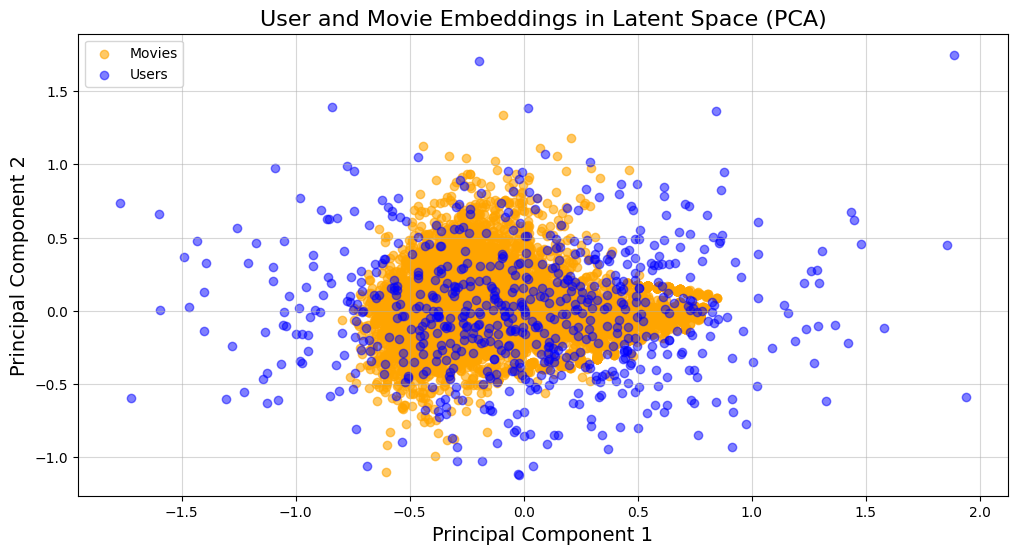

In [334]:
user_pca = PCA(n_components=2).fit_transform(user_embeddings)
movie_pca = PCA(n_components=2).fit_transform(movie_embeddings)

combined_embeddings_2d = np.vstack((user_pca, movie_pca))
labels = ['User'] * user_embeddings.shape[0] + ['Movie'] * movie_embeddings.shape[0]

plt.figure(figsize=(12, 6))

movie_indices = [i for i, l in enumerate(labels) if l == 'Movie']
plt.scatter(
    combined_embeddings_2d[movie_indices, 0],
    combined_embeddings_2d[movie_indices, 1],
    alpha=0.6, 
    color='orange',
    label='Movies'
)

user_indices = [i for i, l in enumerate(labels) if l == 'User']
plt.scatter(
    combined_embeddings_2d[user_indices, 0],
    combined_embeddings_2d[user_indices, 1],
    alpha=0.5, 
    color='blue',
    label='Users'
)

plt.title('User and Movie Embeddings in Latent Space (PCA)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

### Recommendation: id 기반

In [335]:
def recommend_for_user(user_id, top_k=5):
    item_ids = torch.arange(num_items)
    user_ids = torch.LongTensor([user_id] * num_items)

    evaluated_items = set(train_data[train_data['userId'] == user_id]['movieId'])

    with torch.no_grad():
        scores = model(user_ids, item_ids)

    recommended_items = scores.numpy().argsort()[::-1]

    filtered_items = [item for item in recommended_items if item not in evaluated_items]

    reverse_item_map = {v: k for k, v in item_map.items()}
    return [reverse_item_map[item_id] for item_id in filtered_items[:top_k]]

In [336]:
print("Recommendations for User 1:", recommend_for_user(1))

Recommendations for User 1: [2396, 122882, 1035, 2917, 913]


### Recommendation: id to name

In [337]:
movies = pd.read_csv('./dataset/movies_metadata.csv')

movies['id'] = pd.to_numeric(movies['id'], errors='coerce')

movie_id_to_title = (
    movies[['id', 'title']]
    .drop_duplicates()
    .dropna(subset=['id', 'title'])
    .set_index('id')['title']
    .to_dict()
)

links = pd.read_csv('./dataset/links_small.csv')
links['tmdbId'] = pd.to_numeric(links['tmdbId'], errors='coerce')
movie_id_map = links.dropna(subset=['tmdbId']).set_index('movieId')['tmdbId'].to_dict()

final_mapping = {
    movie_id: movie_id_to_title.get(tmdb_id, "Unknown")
    for movie_id, tmdb_id in movie_id_map.items()
}

/var/folders/zz/v63n54yd11g9y43vwk9kw54w0000gn/T/ipykernel_15147/2469967966.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('./dataset/movies_metadata.csv')


### User 별 추천 목록 확인

In [339]:
reverse_item_map = {v: k for k, v in item_map.items()}

user_preferences = (
    train_data[train_data['rating'] > 4]
    .groupby('userId')['movieId']
    .apply(lambda movies: [reverse_item_map[movie] for movie in movies])
    .to_dict()
)

for i in range(5): 
    user_id = i + 1  

    recommendations = recommend_for_user(user_id)
    relevant_movies = user_preferences.get(user_id, [])

    recommended_titles = [final_mapping.get(movie_id, "Unknown") for movie_id in recommendations]
    relevant_titles = [final_mapping.get(movie_id, "Unknown") for movie_id in relevant_movies]

    print(f"\nUser {user_id}:")
    # print(f"  Actual Preferences: {relevant_titles}")
    print(f"  Recommendations:   {recommended_titles}")


User 1:
  Recommendations:   ['Shakespeare in Love', 'Mad Max: Fury Road', 'The Sound of Music', 'Body Heat', 'The Maltese Falcon']

User 2:
  Recommendations:   ['Snatch', 'Catch Me If You Can', 'Donnie Darko', 'Cinema Paradiso', 'Kids']

User 3:
  Recommendations:   ['Pulp Fiction', 'Ran', 'A Little Princess', 'Garden State', "It's a Wonderful Life"]

User 4:
  Recommendations:   ['The Life Aquatic with Steve Zissou', 'Stand by Me', 'Butch Cassidy and the Sundance Kid', 'Rob Roy', 'Ghost']

User 5:
  Recommendations:   ['Fight Club', 'A Clockwork Orange', 'Reservoir Dogs', 'The English Patient', 'Toy Story 3']
